In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import fit_library as fit
import os
import sys
os.environ["ICDIR"] = "/home/viherbos/GITHUB/IC"
sys.path.append('/home/viherbos/GITHUB/IC/Sierpe')
sys.path.append('/home/viherbos/GITHUB/IC/Core')
sys.path.append('/home/viherbos/GITHUB/IC')

import time
import tables
import pandas as pd
import FEE as FE
from DBLR import BLR_ACC2

#%matplotlib nbagg
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
kr2980 = tables.open_file('/mnt/WINDOWS_ntfs/DATOS_DAC/Kriptons/run_2980.gdc1next.000.next1el_2980.root.h5','r+')
pmtrwf = kr2980.root.RD.pmtrwf
feer = FE.FEE(noise_FEEPMB_rms=0.38*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
np.shape(pmtrwf)

(91, 12, 48000)

In [3]:
EVENTO=56


pmt_aux=np.zeros((48000),dtype=float)
pmt=np.zeros((48000,12),dtype=float)

for i in range(0,12):
    pmt_aux=pmtrwf[EVENTO,i].flatten().astype(float)
    pmt[:,i],acum,signal_daq=BLR_ACC2(signal_daq=pmt_aux,
                        coef=feer.coeff_blr_pmt[i],
                        thr=2,
                        acum_FLOOR=2000, 
                        coef_clean=feer.coeff_c_pmt[i],filter=True)
    
    
f=pmt[:,0]+pmt[:,1]+pmt[:,2]+pmt[:,3]+pmt[:,4]+pmt[:,5]+pmt[:,6]+pmt[:,7]+pmt[:,8]+pmt[:,9]+pmt[:,10]+pmt[:,11]

## Noise is in the lower band. LPF to clean the signal. (not needed indeed)

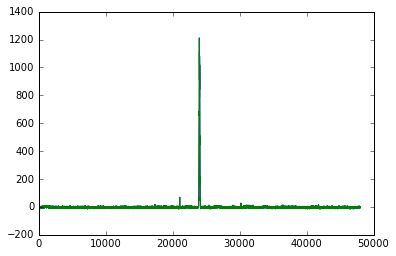

In [4]:
# Note: Use 20 MHz Bandwidth for non filtering effect

signal_in=f-np.mean(f)
f_sample = 40E6
freq_LPF = 20E6*2*np.pi
freq_LPFd = freq_LPF / (f_sample*np.pi)
b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
signal_out = signal.lfilter(b,a,signal_in)


plt.figure(1)
plt.plot(signal_in)
plt.plot(signal_out)
plt.show()

# MAU FILTERING

In [5]:
pmt_nomean=np.zeros((48000,12),dtype=float)
out_signal=np.zeros((48000,12),dtype=float)
MAU_out=np.zeros((48000,12),dtype=float)

MAU_n=200.0;
MAU=np.array(np.ones(MAU_n),dtype=float)*(1/MAU_n)

for i in range(0,12):
    pmt_nomean[:,i]=pmt[:,i]-np.mean(pmt[:,i])
    MAU_out[:,i] = signal.lfilter(MAU,1,pmt_nomean[:,i])
    out_signal[:,i]=pmt_nomean[:,i]-MAU_out[:,i]
    

/home/viherbos/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


# Partial Triggering

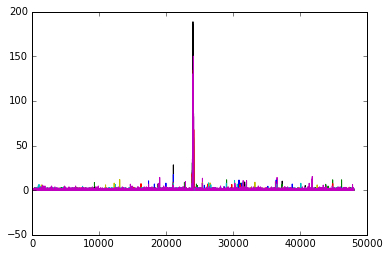

In [6]:
plt.figure()
thr=1.0
pmt_thr=np.zeros((48000,12),dtype=float)

for i in range(0,12):
    pmt_thr[:,i]=(pmt_nomean[:,i]>(MAU_out[:,i]+thr))*pmt_nomean[:,i]
    plt.plot(pmt_thr[:,i])
        
plt.show()

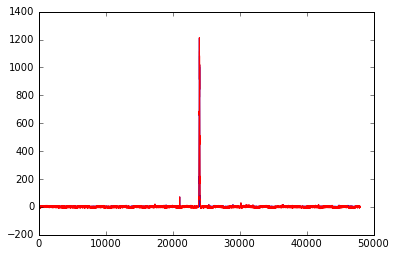

In [7]:
pmt_sum = np.zeros(48000)
for i in range(0,12):
    pmt_sum = pmt_sum + pmt_thr[:,i]


plt.figure()
plt.plot(pmt_sum,'b')
plt.plot(f,'r')
plt.show()

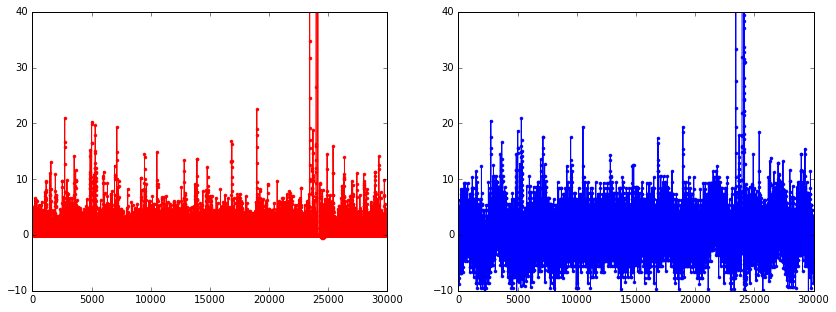

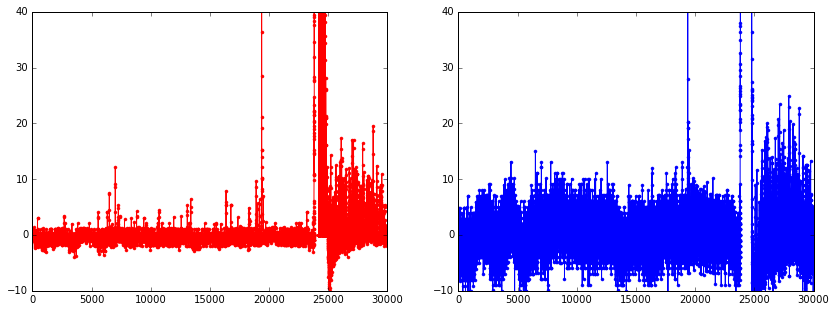

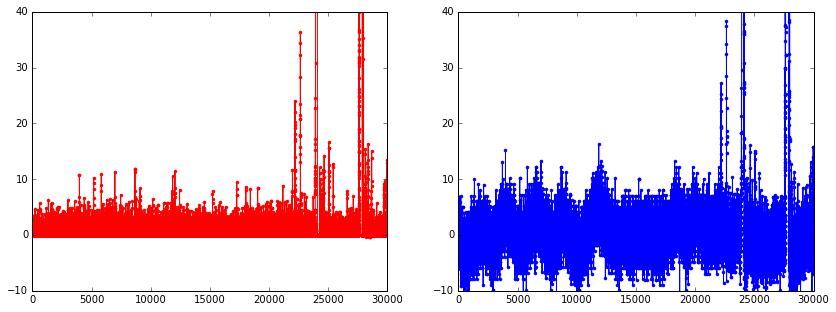

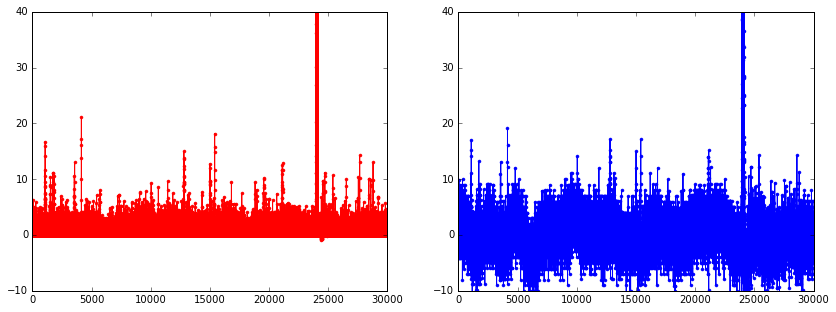

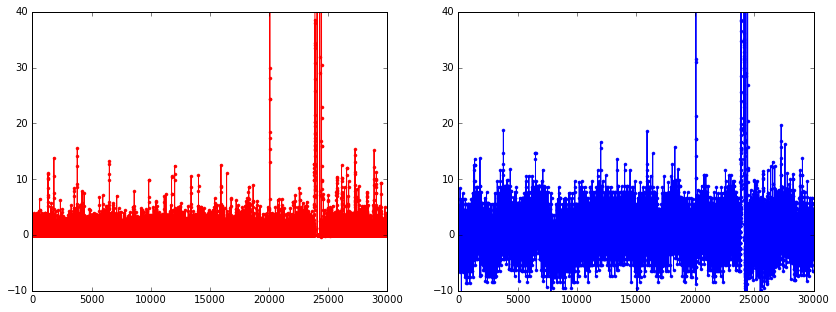

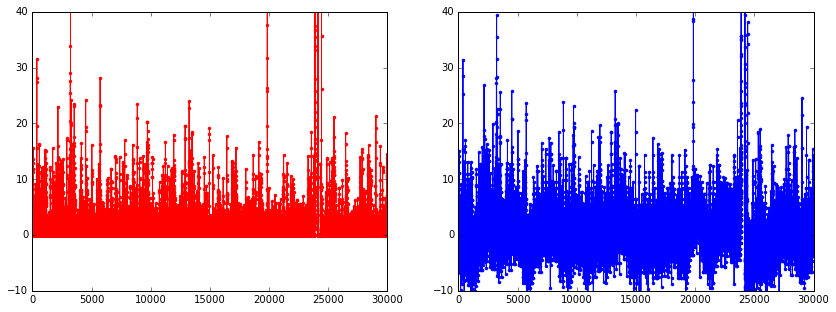

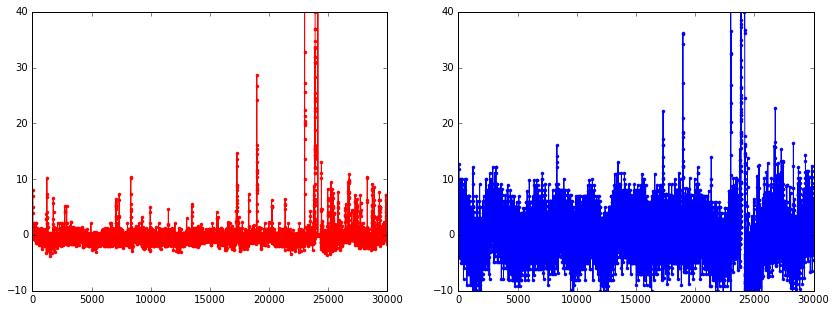

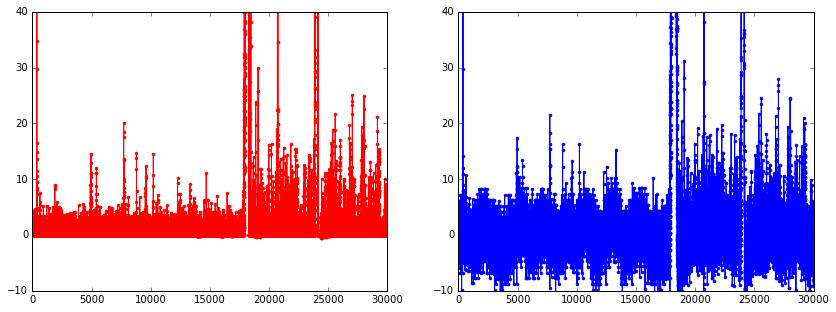

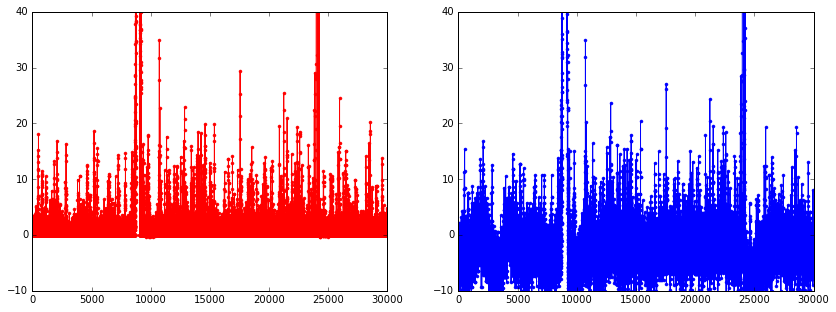

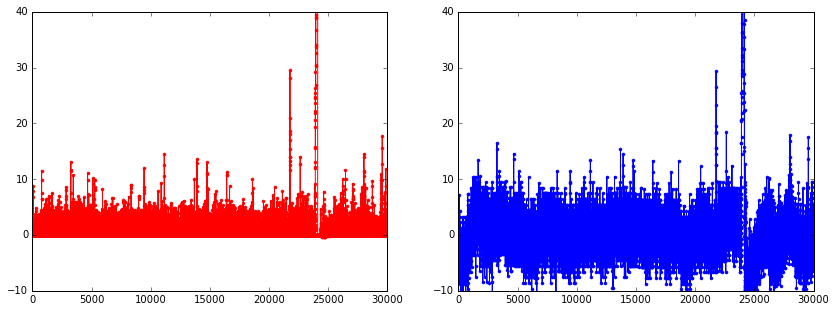

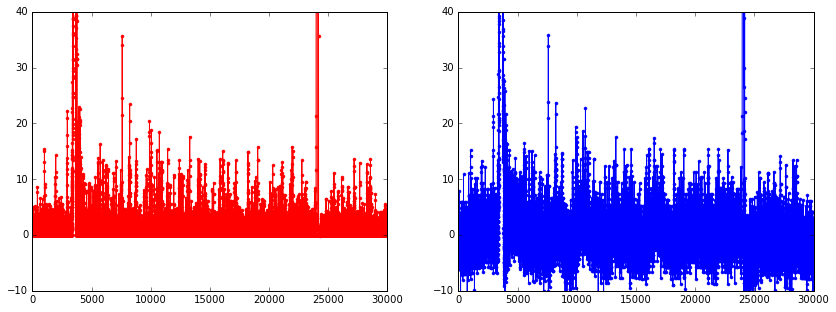

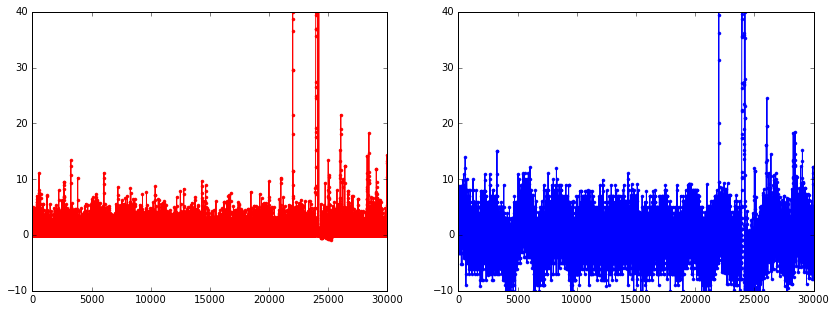

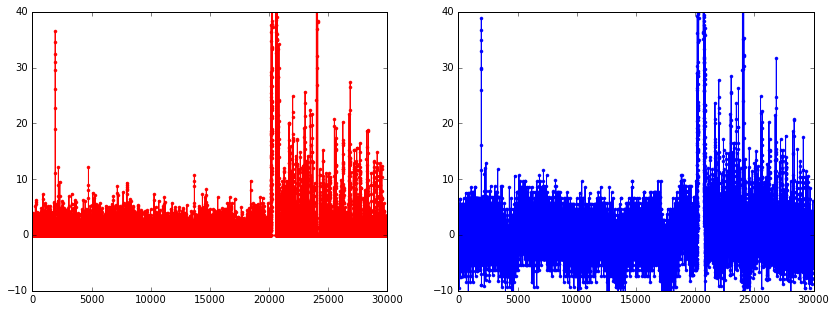

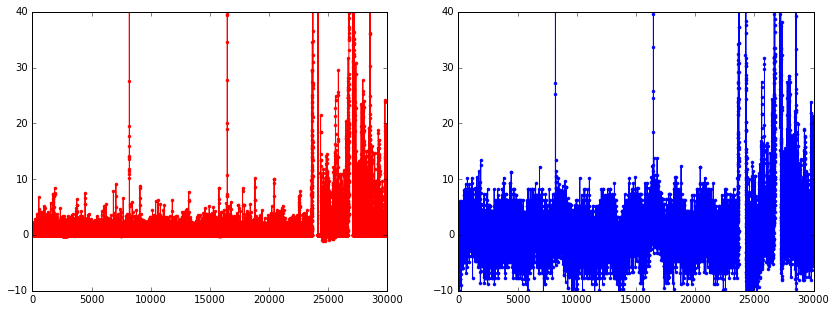

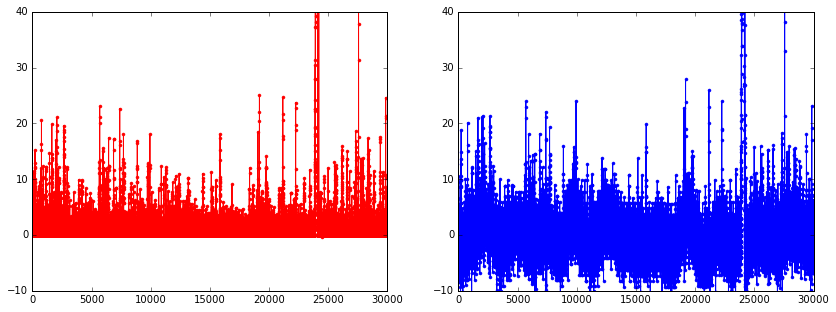

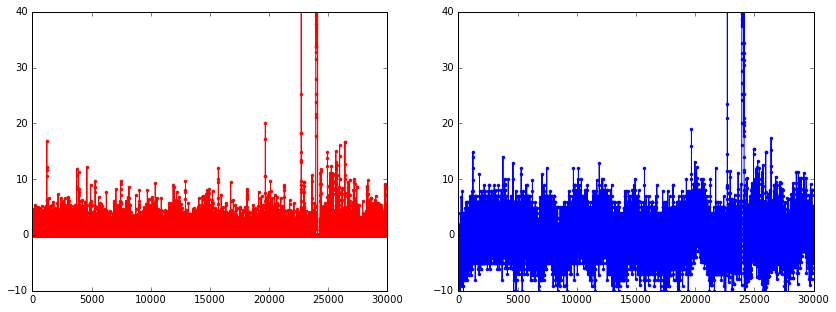

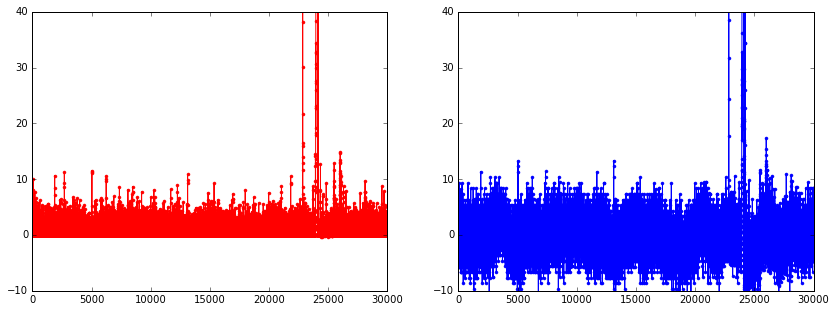

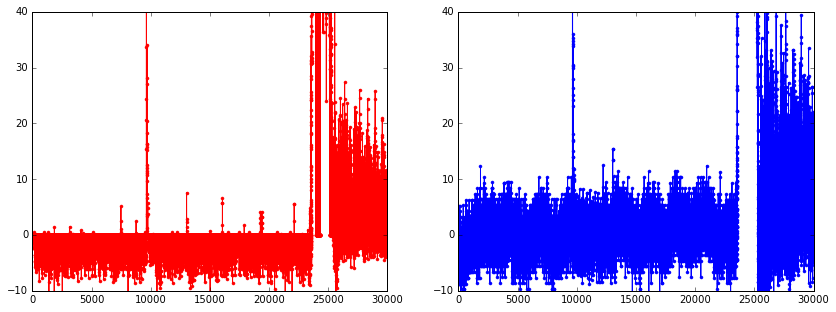

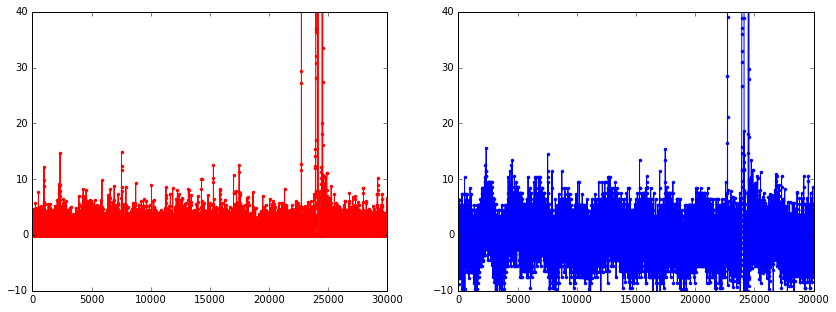

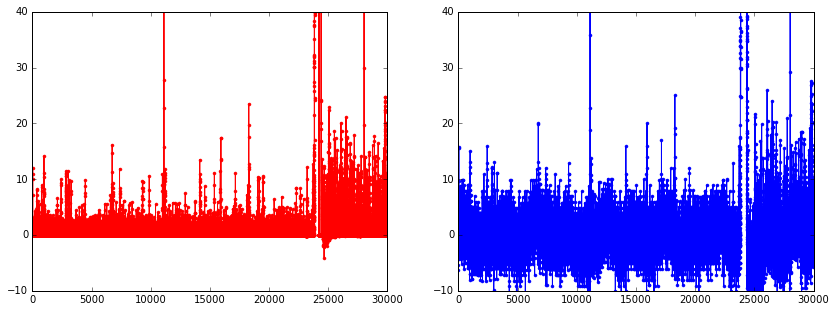

KeyboardInterrupt: 

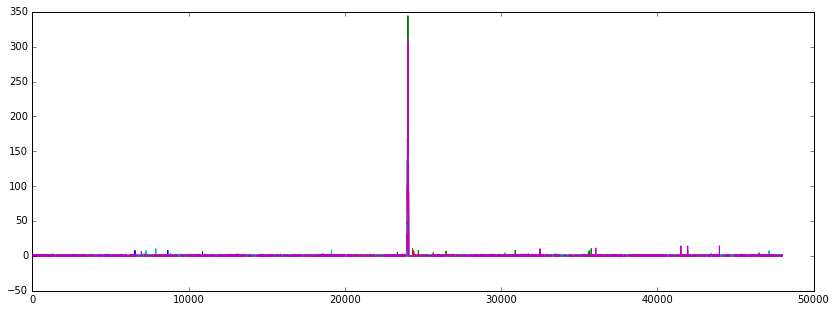

In [9]:
MAU_n=200.0;
#MAU length
MAU=np.array(np.ones(MAU_n),dtype=float)*(1/MAU_n)
thr = 1.2
#Individual Threshold

pmt_aux=np.zeros((48000),dtype=float)
pmt=np.zeros((48000,12),dtype=float)
pmt_nomean=np.zeros((48000,12),dtype=float)
out_signal=np.zeros((48000,12),dtype=float)
MAU_out=np.zeros((48000,12),dtype=float)
pmt_thr=np.zeros((48000,12),dtype=float)
pmt_sum_thr = np.zeros((48000,100),dtype=float)
pmt_sum = np.zeros((48000,100),dtype=float)



for EVENTO in range(0,91):

    plt.figure(figsize=(14, 5))
    
    for i in range(0,12):
        pmt_aux=pmtrwf[EVENTO,i].flatten().astype(float)
        pmt[:,i],acum,signal_daq=BLR_ACC2(signal_daq=pmt_aux,
                            coef=feer.coeff_blr_pmt[i],
                            thr=2,
                            acum_FLOOR=2000, 
                            coef_clean=feer.coeff_c_pmt[i],filter=True)

        pmt_nomean[:,i]=pmt[:,i]-np.mean(pmt[:,i])
        MAU_out[:,i] = signal.lfilter(MAU,1,pmt_nomean[:,i])
        #out_signal[:,i]=pmt_nomean[:,i]-MAU_out[:,i]

        pmt_thr[:,i]=(pmt_nomean[:,i]>(MAU_out[:,i]+thr))*pmt_nomean[:,i]
        plt.plot(pmt_thr[:,i])

        pmt_sum_thr[:,EVENTO] = pmt_sum_thr[:,EVENTO] + pmt_thr[:,i]
        pmt_sum[:,EVENTO] = pmt_sum[:,EVENTO] + pmt[:,i]
        
    plt.subplot(121)    
    plt.plot(pmt_sum_thr[:,EVENTO],'r.-')
    axes = plt.gca()
    axes.set_ylim([-10,40])
    axes.set_xlim([0,30000])
    plt.subplot(122)    
    plt.plot(pmt_sum[:,EVENTO],'b.-')
    axes = plt.gca()
    axes.set_ylim([-10,40])
    axes.set_xlim([0,30000])
    plt.show()
